In [4]:
#Preprocessing Phase 1 - Resolving Empty Fields and Bad data
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import display, HTML
import pandas as pd
import pickle
import joblib
from joblib import parallel_backend
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from dask.distributed import Client

In [3]:
df = pd.read_csv('Andhra_Health_Data.csv');
display(HTML(df.head(5).to_html()))

,Sno,AGE,SEX,CASTE_NAME,CATEGORY_CODE,CATEGORY_NAME,SURGERY_CODE,SURGERY,VILLAGE,MANDAL_NAME,DISTRICT_NAME,PREAUTH_DATE,PREAUTH_AMT,CLAIM_DATE,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_DISTRICT,SURGERY_DATE,DISCHARGE_DATE,Mortality Y / N,MORTALITY_DATE,SRC_REGISTRATION
0,1,56,Female,BC,M6,NEPHROLOGY,M6.5,Maintenance Hemodialysis For Crf,Lolugu,Ponduru,Srikakulam,3/8/2013 20:38,12500,22-03-2017 20:25,11000,"Rims Govt. General Hospital, Srikakulam",G,Srikakulam,6/8/2013 0:00,7/9/2013 0:00,NO,NaN,D
1,2,37,Male,BC,M6,NEPHROLOGY,M6.5,Maintenance Hemodialysis For Crf,Borivanka,Kaviti,Srikakulam,6/8/2013 7:26,12500,22-03-2017 20:25,11000,"Rims Govt. General Hospital, Srikakulam",G,Srikakulam,8/8/2013 0:00,9/9/2013 0:00,NO,NaN,D
2,3,50,Male,BC,M6,NEPHROLOGY,M6.5,Maintenance Hemodialysis For Crf,Kapasakuddi,Kaviti,Srikakulam,9/8/2013 18:30,12500,22-03-2017 20:25,11500,"Rims Govt. General Hospital, Srikakulam",G,Srikakulam,15-08-2013 00:00,18-10-2013 00:00,NO,NaN,D
3,4,45,Male,BC,M6,NEPHROLOGY,M6.5,Maintenance Hemodialysis For Crf,Telikipenta,Sarubujjili,Srikakulam,24-08-2013 19:37,12500,22-03-2017 20:25,11000,"Rims Govt. General Hospital, Srikakulam",G,Srikakulam,24-08-2013 00:00,27-09-2013 00:00,NO,NaN,D
4,5,54,Male,BC,M6,NEPHROLOGY,M6.5,Maintenance Hemodialysis For Crf,Thandemvalasa,Srikakulam,Srikakulam,28-08-2013 17:03,12500,22-03-2017 20:25,11000,"Rims Govt. General Hospital, Srikakulam",G,Srikakulam,31-08-2013 00:00,2/10/2013 0:00,NO,NaN,D


In [4]:
df.info()
cols = df.columns

for i in cols:
    print(i, ',', df[i].dtype,',',df[i].isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479688 entries, 0 to 479687
Data columns (total 23 columns):
Sno                 479688 non-null int64
AGE                 479688 non-null int64
SEX                 479688 non-null object
CASTE_NAME          479688 non-null object
CATEGORY_CODE       479688 non-null object
CATEGORY_NAME       479688 non-null object
SURGERY_CODE        479688 non-null object
SURGERY             479688 non-null object
VILLAGE             479688 non-null object
MANDAL_NAME         479688 non-null object
DISTRICT_NAME       479688 non-null object
PREAUTH_DATE        479688 non-null object
PREAUTH_AMT         479688 non-null int64
CLAIM_DATE          479688 non-null object
CLAIM_AMOUNT        479688 non-null int64
HOSP_NAME           479688 non-null object
HOSP_TYPE           479688 non-null object
HOSP_DISTRICT       479688 non-null object
SURGERY_DATE        479688 non-null object
DISCHARGE_DATE      475128 non-null object
Mortality Y / N     479688 non-nu

In [ ]:
#Blank cells in "DISCHAREGE_DATE"  and "MORTALITY_DATE" are observed.
# MORTALITY_DATE is date on which patient dies. IF it is blank that means patient was alive after treatment.
# In that case the DISCHARGE_DATE is blank. So we will populate empty DISCHARGE_DATE with MORTALITY_DATE

In [5]:
df['DISCHARGE_DATE'] = df['DISCHARGE_DATE'].combine_first(df['MORTALITY_DATE'])

In [ ]:
# Further we need to check if any row exist where both column "DISCHARGE_DATE" and "MORTALITY_DATE" are blank

In [6]:
x = df[(df['DISCHARGE_DATE']).isnull() & (df['MORTALITY_DATE']).isnull()]
print("x:",x)

x:            Sno  AGE   SEX CASTE_NAME CATEGORY_CODE CATEGORY_NAME SURGERY_CODE  \
148162  148163   51  Male         SC            M6    NEPHROLOGY         M6.5   

                                 SURGERY       VILLAGE    MANDAL_NAME  ...  \
148162  Maintenance Hemodialysis For Crf  Venkatapuram  Banaganapalle  ...   

              CLAIM_DATE CLAIM_AMOUNT  \
148162  25-05-2017 20:39        12500   

                                                HOSP_NAME HOSP_TYPE  \
148162  OMNI Hospitals, a unit of Ms. Incor Padmachand...         C   

        HOSP_DISTRICT      SURGERY_DATE DISCHARGE_DATE Mortality Y / N  \
148162        Kurnool  27-12-2016 00:00            NaN              NO   

       MORTALITY_DATE SRC_REGISTRATION  
148162            NaN                D  

[1 rows x 23 columns]


In [ ]:
# Because only one such row exist, (148162), We will investigate if dataset is imbalanced or not.
# If dataset is imbalanced,and row is in majority then we will drop this row, else we will retain it.

In [7]:
#Our target column is "Morality Y/N", So we will investigate this column.
print("Target Column analysis")
print(df["Mortality Y / N"].value_counts())

Target Column analysis
NO     469566
YES     10122
Name: Mortality Y / N, dtype: int64


In [8]:
# Since NO is 469566 and YES is 10122, dataset is imbalanced and row x(148162) is in majority, so we will drop this row.
#Discahrge_Date has only one row with empty value. So we will implement this.
df=df[df['DISCHARGE_DATE'].notna()]

In [9]:
#We start preprocessing by dropping unnecessary column.
df=df.drop('Sno',axis=1) #We drop first column Sno, which is index column
df = df.drop('MORTALITY_DATE',axis=1) #Mortality Date is the date when patient died. We are droppinng this because we have "Mortality Y/N" Column, which says if patient is dead or not. We dont need to know when patient died.
df = df.drop('CLAIM_DATE',axis=1)  #The date patient receives his claim. This date comes way after patient is discharged or dies during surgery.
df = df.drop('CLAIM_AMOUNT',axis=1) #The Amount received by patient after surgery is performed. It could e less than or equal to PreAuth Amount.
df = df.drop('CATEGORY_NAME',axis=1) #We are Dropping Category_Name because We have "CATEGORY_CODE" column which is mapped with each category.
df = df.drop('SURGERY',axis=1)  #We are dropping "SURGERY" Column because we have "SURGERY_CODE" column mapped with "SURGERY" Column

In [10]:
#The SEX column has 4 vales -Male,Female, Male(Child) and Female(Child)
# Child label is applied to patient whose age is between 0-14
# We convert Male(Child)  to Male and similarly Female(Child) to Female
# because we already have age column.
df['SEX'] = df['SEX'].replace(['Male(Child)'],'Male');
df['SEX'] = df['SEX'].replace(['MALE'],'Male');
df['SEX'] = df['SEX'].replace(['Female(Child)'],'Female');
df['SEX'] = df['SEX'].replace(['FEMALE'],'Female');

In [11]:
cols = df.columns
for i in cols:
 print(i, ',', df[i].dtype,',',df[i].isnull().any())
# Now we need to fill blank cells in "DISCHARGE_DATE" column only.

AGE , int64 , False
SEX , object , False
CASTE_NAME , object , False
CATEGORY_CODE , object , False
SURGERY_CODE , object , False
VILLAGE , object , False
MANDAL_NAME , object , False
DISTRICT_NAME , object , False
PREAUTH_DATE , object , False
PREAUTH_AMT , int64 , False
HOSP_NAME , object , False
HOSP_TYPE , object , False
HOSP_DISTRICT , object , False
SURGERY_DATE , object , False
DISCHARGE_DATE , object , False
Mortality Y / N , object , False
SRC_REGISTRATION , object , False


In [12]:
#Before that we need to keep all date columns in single date format.
#Date is in two formats. One is DD-MM-YYYY HH:MM. Other is DD/MM/YYYY HH:MM
#Below code snippet will give all dates in MM/DD/YYYY HH:MM Format and convert to unix format

df['PREAUTH_DATE'] = pd.to_datetime(df['PREAUTH_DATE'], infer_datetime_format=True, dayfirst=True)

In [13]:
df['SURGERY_DATE'] = pd.to_datetime(df['SURGERY_DATE'], infer_datetime_format=True, dayfirst=True)
#df['SURGERY_DATE'] = df['SURGERY_DATE'].values.astype(np.int64)

#We observed that one date in "DISCHARGE_DATE" column wast stored as 30/04/0116. When we checked for same row "mortality date" column it was 30/04/2016.
#Since "MORTALITY Y/N" Column is marked Yes, We replace 30/04/0116 with 30/04/2016

In [14]:
p = df[df['DISCHARGE_DATE'] == "30/04/0116 00:00:00"]
print(p)
# dataframe p shows 2 rows where above bad date is stored. We will replace that date with Mortality date

      AGE   SEX CASTE_NAME CATEGORY_CODE SURGERY_CODE        VILLAGE  \
1767   44  Male         ST            M6         M6.5     Ratnapuram   
2856   44  Male         ST            M6         M6.5  Kusumanapalli   

       MANDAL_NAME  DISTRICT_NAME        PREAUTH_DATE  PREAUTH_AMT  \
1767       Chintur  East Godavari 2016-01-27 01:00:00        12500   
2856  Bhadrachalam  East Godavari 2016-02-26 18:33:00        12500   

                       HOSP_NAME HOSP_TYPE HOSP_DISTRICT SURGERY_DATE  \
1767  District Hospital-Khammam-         G       Khammam   2016-01-27   
2856  District Hospital-Khammam-         G       Khammam   2016-03-02   

           DISCHARGE_DATE Mortality Y / N SRC_REGISTRATION  
1767  30/04/0116 00:00:00             YES                D  
2856  30/04/0116 00:00:00             YES                D  


In [15]:
df['DISCHARGE_DATE'] = df['DISCHARGE_DATE'].replace(['30/04/0116 00:00:00'],'30-04-2016 00:00')

p = df[df['DISCHARGE_DATE'] == "30/04/0116 00:00:00"]
print(p)
#P is empty, Hence no bad date further exist

Empty DataFrame
Columns: [AGE, SEX, CASTE_NAME, CATEGORY_CODE, SURGERY_CODE, VILLAGE, MANDAL_NAME, DISTRICT_NAME, PREAUTH_DATE, PREAUTH_AMT, HOSP_NAME, HOSP_TYPE, HOSP_DISTRICT, SURGERY_DATE, DISCHARGE_DATE, Mortality Y / N, SRC_REGISTRATION]
Index: []


In [16]:
df['DISCHARGE_DATE'] = pd.to_datetime(df['DISCHARGE_DATE'], infer_datetime_format=True, dayfirst=True)

In [17]:
df["Diff_SURGERY_PREAUTH"]= (df["SURGERY_DATE"] - df["PREAUTH_DATE"]).dt.days
df["Diff_Discharge_PREAUTH"] = (df["DISCHARGE_DATE"] - df["PREAUTH_DATE"]).dt.days
df=df.drop('SURGERY_DATE',axis=1)
df=df.drop('PREAUTH_DATE',axis=1)
df=df.drop('DISCHARGE_DATE',axis=1)
#All DateColumns are processesed and save as Python Date Object. We drop all original columns

In [18]:
#We save this data for further processing
df.to_csv("file.csv",index=False)

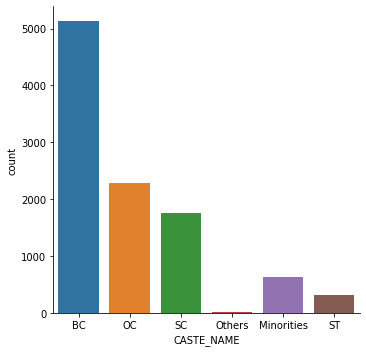

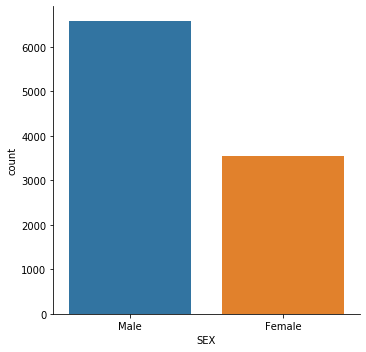

In [92]:
#Analysis
import seaborn as sn 

df = pd.read_csv("file.csv")
df1  =  df[df["Mortality Y / N"]=="YES"]
sn.factorplot('CASTE_NAME',data = df1, kind='count')
sn.factorplot('SEX',data = df1, kind='count')

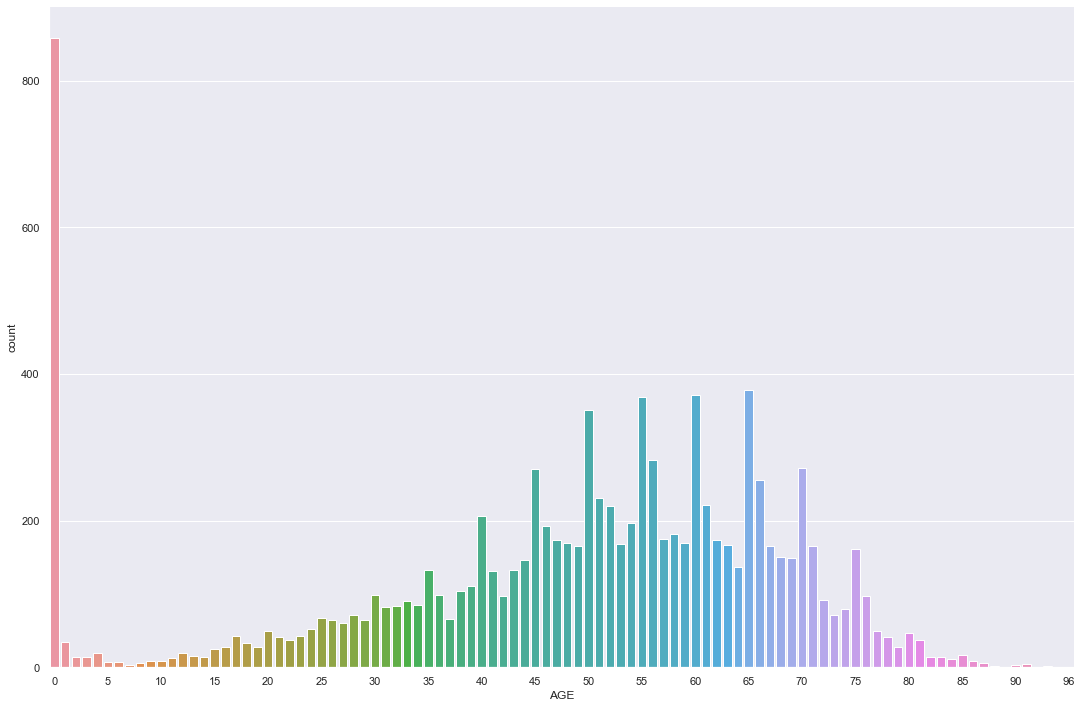

In [101]:
pl=sn.factorplot('AGE',data = df1, kind='count', height = 10, aspect = 15/10)
pl.set_xticklabels(step=5)

Nellore           1255
West Godavari      988
Guntur             914
Kurnool            892
Chittoor           862
Krishna            840
East Godavari      801
Vishakhapatnam     794
Prakasam           733
YSR Kadapa         542
Anantapur          504
Vizianagaram       500
Srikakulam         497
Name: DISTRICT_NAME, dtype: int64

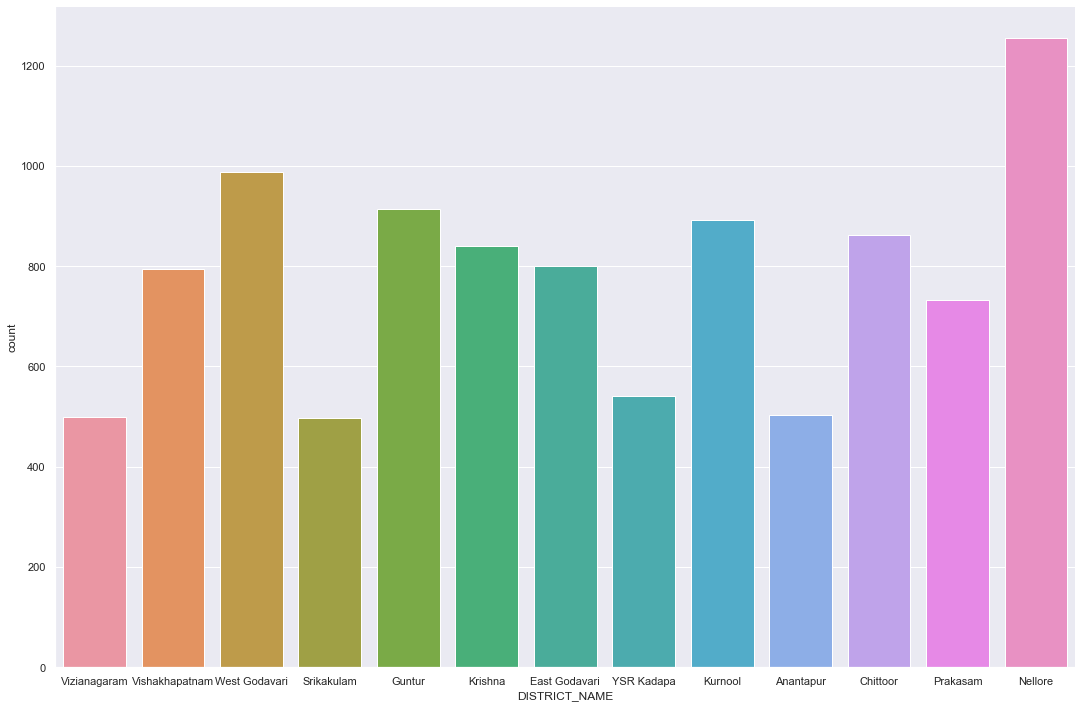

In [100]:
sn.factorplot('DISTRICT_NAME',data = df1, kind='count', height = 10, aspect = 15/10)
df1['DISTRICT_NAME'].value_counts()

C    6128
G    3994
Name: HOSP_TYPE, dtype: int64

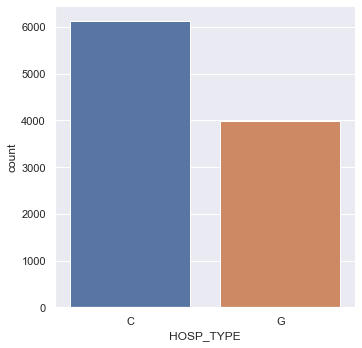

In [103]:
sn.factorplot('HOSP_TYPE',data = df1, kind='count')
df1['HOSP_TYPE'].value_counts()

D      9247
P       418
CMO     271
MC      186
Name: SRC_REGISTRATION, dtype: int64

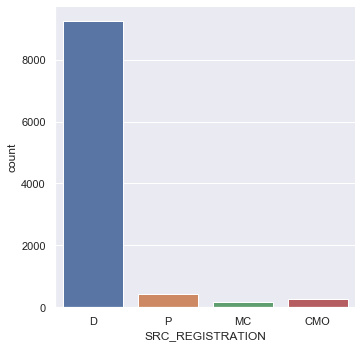

In [104]:
sn.factorplot('SRC_REGISTRATION',data = df1, kind='count')
df1['SRC_REGISTRATION'].value_counts()

-2     2054
-3     1491
-1     1106
-4      914
 0      863
       ... 
 35       1
-94       1
 74       1
 34       1
 63       1
Name: Diff_SURGERY_PREAUTH, Length: 95, dtype: int64

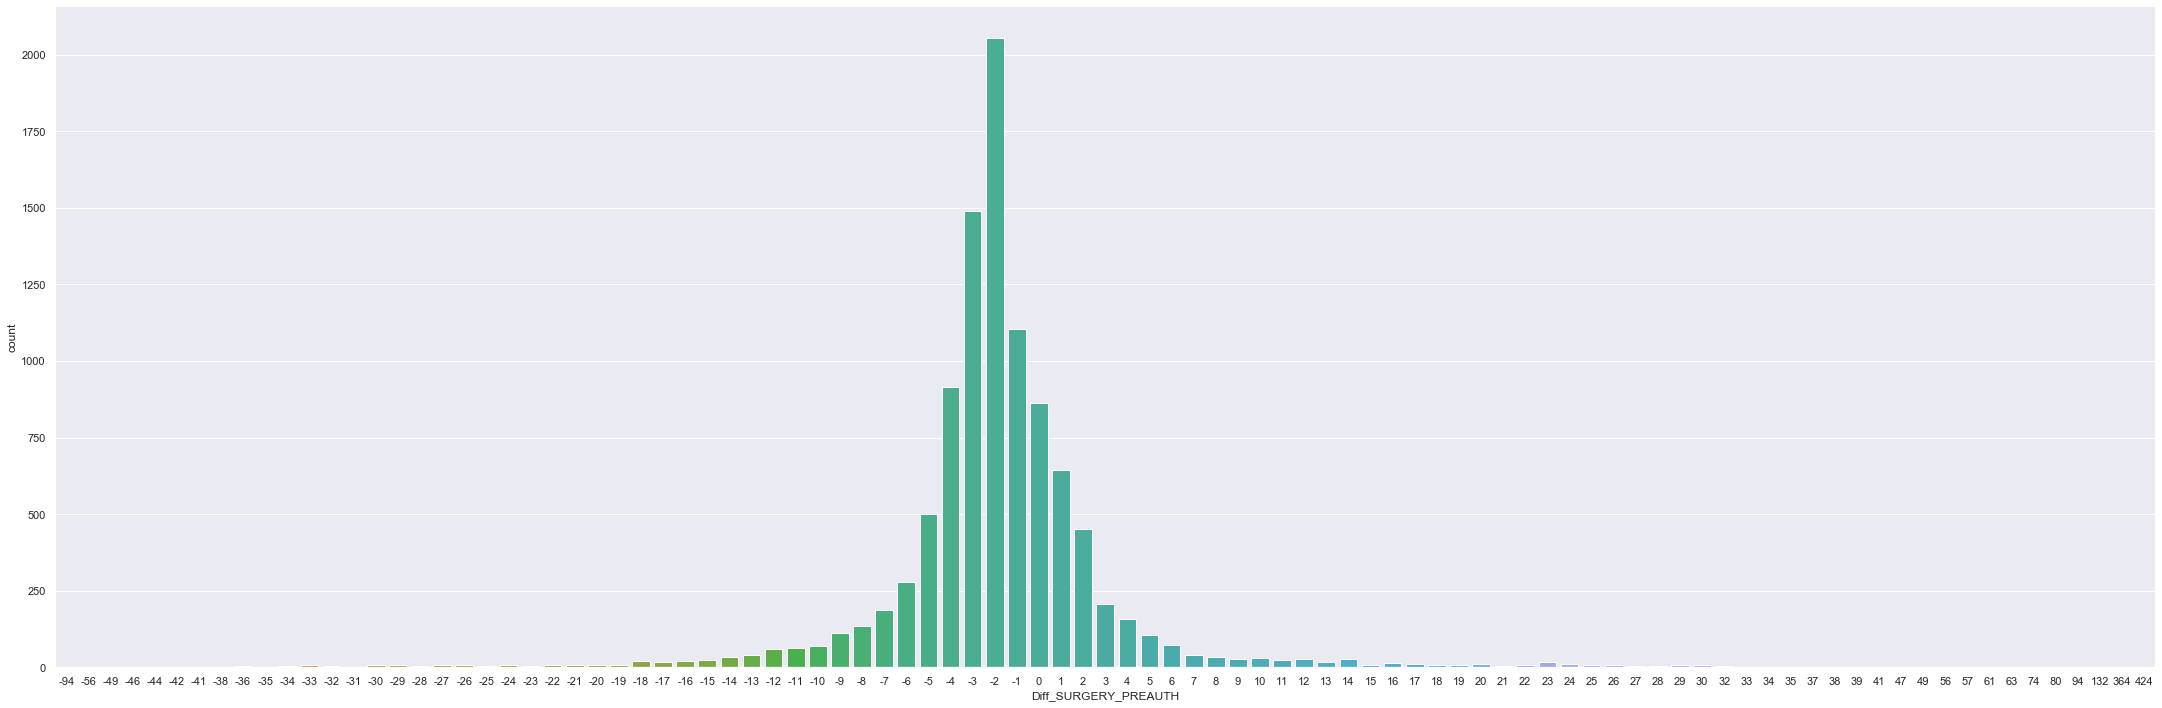

In [109]:
sn.factorplot('Diff_SURGERY_PREAUTH',data = df1, kind='count',height = 10, aspect = 30/10)
df1['Diff_SURGERY_PREAUTH'].value_counts()

-1      944
 0      752
-2      729
 1      686
 2      568
       ... 
-36       1
 84       1
 100      1
 116      1
 203      1
Name: Diff_Discharge_PREAUTH, Length: 170, dtype: int64

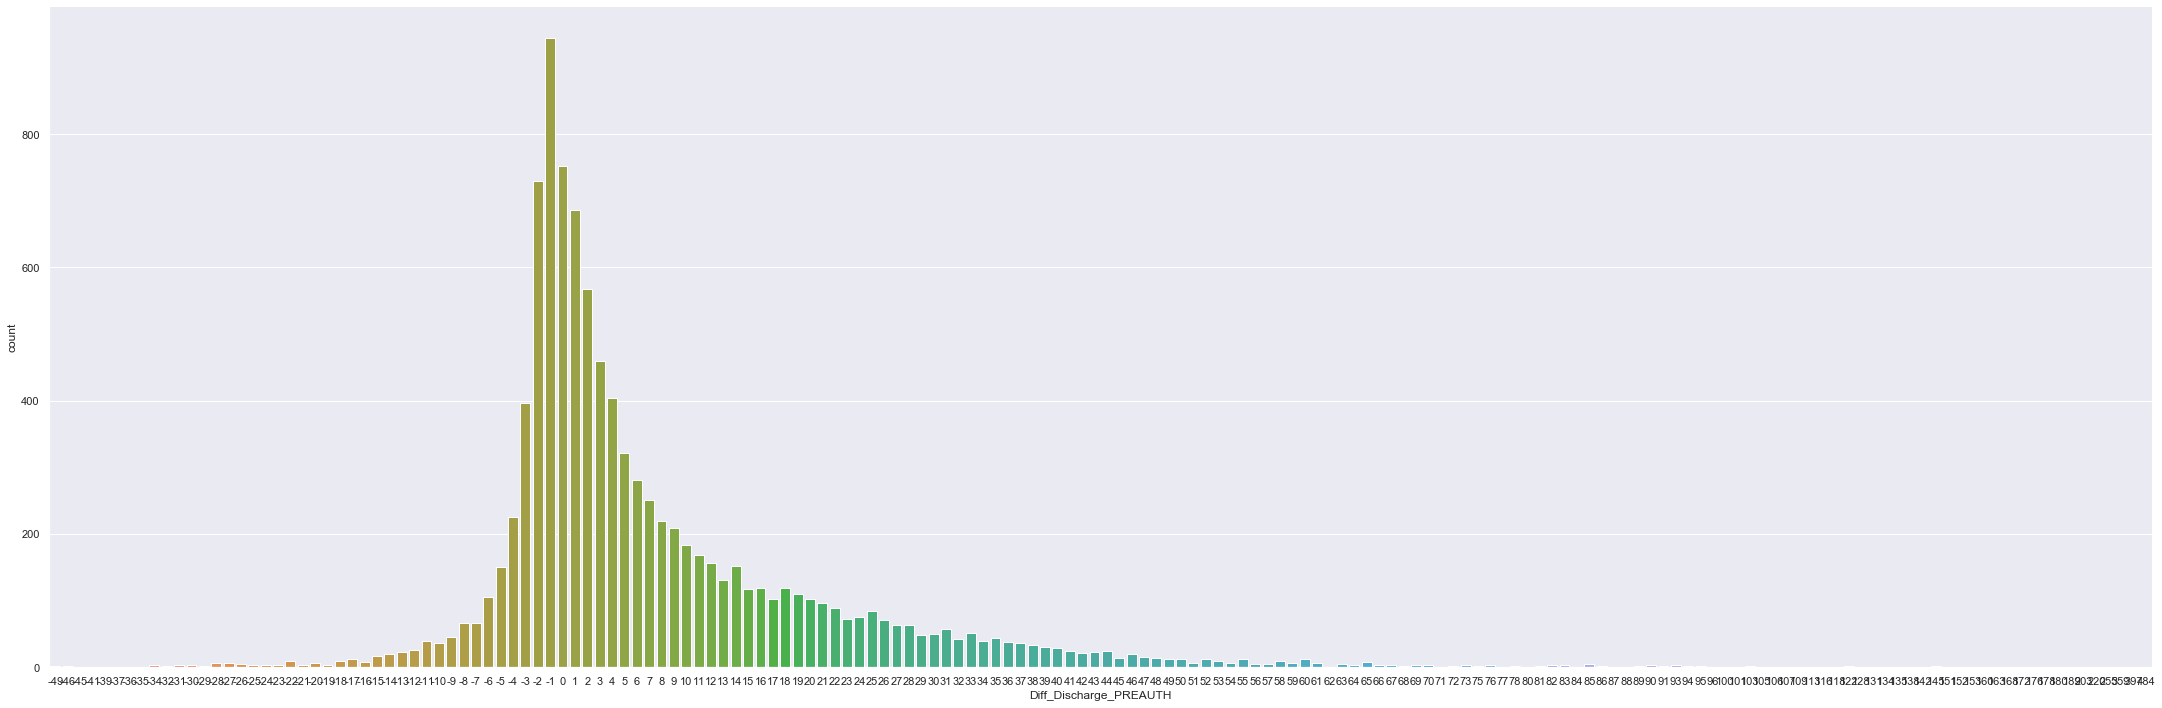

In [111]:
sn.factorplot('Diff_Discharge_PREAUTH',data = df1, kind='count',height = 10, aspect = 30/10)
df1['Diff_Discharge_PREAUTH'].value_counts()

In [ ]:
#Preprocessing Phase 2 - Resolving Class Imbalance
#Dataset has column "Mortality Y / N" which has value "YES" and "NO"
# They are our target columns. It has 10,122 rows marked as "YES" and 469,565 marked as "NO"
# We consider all rows (10,122) in file.csv marked as "YES" for final preprocessing
# We also consider additional 23,367 rows marked as "NO" (out of 469,565) in final dataset.
# All rows in the dataset will contain all surgeries, villages and hospital name at least once which was earlier mentioned in original dataset

In [186]:
import pandas as pd
df = pd.read_csv('file.csv');

In [187]:
#Apply filter to obtain rows of 2 different class
df1  =  df[df["Mortality Y / N"]=="YES"]
print("len df1:",len(df1))
df2  =  df[df["Mortality Y / N"]=="NO"]
print("len df2:",len(df2),"\n")

len df1: 10122
len df2: 469565 



In [210]:
dist =  df1["SURGERY_CODE"].unique() #obtain all surgery_code mentioned in "SURGERY_CODE" column

df3  = pd.DataFrame()
chunks = [];
for x in dist:
    df_i1 = df1[df1["SURGERY_CODE"]  == x]  #Mortality = y & Surgery = x
    length_y = len(df_i1)
    df_i2 = df2[df2["SURGERY_CODE"]  == x]  #Mortality = N & Surgery = x
    length_n = len(df_i2)
    #print(x," length1:", length1," length2:", length2)
    if length_y < length_n:
        df_i3 = df_i2.sample(n=length_y, replace=False)   #Select equal number of Mortality = "Yes" and Mortality = "No" for each surgery
        chunks.append(df_i3)
    #if length_n > length_y:
     #   df_i3 = df_i1.sample(n=length_n, replace=False)
      #  chunks.append(df_i1)
     
        
df3 = pd.concat(chunks, ignore_index=True) #join all the dataframe chunks

frame = [df3, df1]
df5 = pd.concat(frame, ignore_index=True)

In [211]:
df3.info()
df3["Mortality Y / N"].value_counts()
df5.info()
df5["Mortality Y / N"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 16 columns):
AGE                       9951 non-null int64
SEX                       9951 non-null object
CASTE_NAME                9951 non-null object
CATEGORY_CODE             9951 non-null object
SURGERY_CODE              9951 non-null object
VILLAGE                   9951 non-null object
MANDAL_NAME               9951 non-null object
DISTRICT_NAME             9951 non-null object
PREAUTH_AMT               9951 non-null int64
HOSP_NAME                 9951 non-null object
HOSP_TYPE                 9951 non-null object
HOSP_DISTRICT             9951 non-null object
Mortality Y / N           9951 non-null object
SRC_REGISTRATION          9951 non-null object
Diff_SURGERY_PREAUTH      9951 non-null int64
Diff_Discharge_PREAUTH    9951 non-null int64
dtypes: int64(4), object(12)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20073 entries, 0 to 20072
Data columns (tota

YES    10122
NO      9951
Name: Mortality Y / N, dtype: int64

In [213]:
dist2 = df["SURGERY_CODE"].unique()
dist3 = df5["SURGERY_CODE"].unique()
dist4 = sorted(list(set(dist2) - set(dist3))) #List of surgery code missed out in previous operation are added

In [216]:
chunks=[]
for x in dist4:
    df_i2 = df2[df2["SURGERY_CODE"] == x] #Mortality = N & Surgery = x
    df_i4 = df_i2.sample() #Randomly, one row is selected with missing surgery_code and then added to dataframe
    chunks.append(df_i4)

df4= pd.concat(chunks, ignore_index=True)

frame = [df5, df4]
df6 = pd.concat(frame, ignore_index=True)
df6.to_csv("file2.csv")
df6 =  df5.drop_duplicates(keep = 'first')
df6.info()
df6["Mortality Y / N"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20048 entries, 0 to 20072
Data columns (total 16 columns):
AGE                       20048 non-null int64
SEX                       20048 non-null object
CASTE_NAME                20048 non-null object
CATEGORY_CODE             20048 non-null object
SURGERY_CODE              20048 non-null object
VILLAGE                   20048 non-null object
MANDAL_NAME               20048 non-null object
DISTRICT_NAME             20048 non-null object
PREAUTH_AMT               20048 non-null int64
HOSP_NAME                 20048 non-null object
HOSP_TYPE                 20048 non-null object
HOSP_DISTRICT             20048 non-null object
Mortality Y / N           20048 non-null object
SRC_REGISTRATION          20048 non-null object
Diff_SURGERY_PREAUTH      20048 non-null int64
Diff_Discharge_PREAUTH    20048 non-null int64
dtypes: int64(4), object(12)
memory usage: 2.6+ MB


YES    10119
NO      9929
Name: Mortality Y / N, dtype: int64

In [219]:
x = 10119 - 9929
df_ = df2.sample(n=x, replace=False)
frame = [df6, df_]
df6 = pd.concat(frame, ignore_index=True)
df6 = df6.drop_duplicates(keep = 'first')
df6.info()
df6["Mortality Y / N"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20416 entries, 0 to 20422
Data columns (total 16 columns):
AGE                       20416 non-null int64
SEX                       20416 non-null object
CASTE_NAME                20416 non-null object
CATEGORY_CODE             20416 non-null object
SURGERY_CODE              20416 non-null object
VILLAGE                   20416 non-null object
MANDAL_NAME               20416 non-null object
DISTRICT_NAME             20416 non-null object
PREAUTH_AMT               20416 non-null int64
HOSP_NAME                 20416 non-null object
HOSP_TYPE                 20416 non-null object
HOSP_DISTRICT             20416 non-null object
Mortality Y / N           20416 non-null object
SRC_REGISTRATION          20416 non-null object
Diff_SURGERY_PREAUTH      20416 non-null int64
Diff_Discharge_PREAUTH    20416 non-null int64
dtypes: int64(4), object(12)
memory usage: 2.6+ MB


NO     10297
YES    10119
Name: Mortality Y / N, dtype: int64

In [220]:
file1 = open("file2.csv","w")
file1.truncate(0)
file1.close()
df6.to_csv("file2.csv")

In [ ]:
#Preprocessing phase 3 - preparing dataset for Naive Bayes, Logistic Regression and Decision Tree

In [5]:
df = pd.read_csv('file2.csv');
df = df.drop(df.columns[0], axis=1)

df_raw=df.copy(deep=True)
df_nb = df_raw.copy(deep =True)
print("read copy successful")
#Bin conversion for numerical data
df_nb['AGE'] = pd.cut(df_nb['AGE'],10)
df_nb['PREAUTH_AMT'] = pd.cut(df_nb['PREAUTH_AMT'],6)
df_nb['Diff_SURGERY_PREAUTH'] = pd.cut(df_nb['Diff_SURGERY_PREAUTH'],7)
df_nb['Diff_Discharge_PREAUTH'] = pd.cut(df_nb['Diff_Discharge_PREAUTH'],9)

client = Client(processes = False) #dask is running at backend for joblib

read copy successful


In [6]:
with parallel_backend('dask'):
 y = df_nb['Mortality Y / N']
 le = preprocessing.LabelEncoder()
 le.fit(y)
 y_encoded = le.transform(y) # encode nominal labels to integers #####################################
print("y_encoded obtained")

with parallel_backend('dask'):
 df_nb = pd.get_dummies(df_nb.drop('Mortality Y / N',axis=1))
print("df_nb obtained")

y_encoded obtained
df_nb obtained


In [7]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Columns: 7462 entries, AGE_(-0.096, 9.6] to Diff_Discharge_PREAUTH_(424.778, 484.0]
dtypes: uint8(7462)
memory usage: 145.3 MB


In [8]:
file1 = open("df_nb.csv","w")
file1.truncate(0)
file1.close()
df_nb.to_csv("df_nb.csv", index=False)


#splitting data
x_train, x_test, y_train, y_test = train_test_split(df_nb, y_encoded, test_size=0.3)
print("train,test split")

train,test split


In [9]:
clf1 = GaussianNB()
clf2 = LogisticRegression()
clf3 = DecisionTreeClassifier()

In [10]:
#path where models are saved are cleared
filename1  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\NaiveBayes.sav'
filename2  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\LogisticRegression.sav'
filename3  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\DecisionTree.sav'

filename4  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\KNN.sav'
filename5  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\SVM.sav'
filename6  = 'C:\\Jupyter Notebook\\ITMD_525 Data Mining Project\\models\\NN.sav'



file = open(filename1,'r+')
file.truncate(0)
file.close()
print("file is closed")

file = open(filename2,'r+')
file.truncate(0)
file.close()
print("file is closed")

file = open(filename3,'r+')
file.truncate(0)
file.close()
print("file is closed")

file = open(filename4,'r+')
file.truncate(0)
file.close()
print("file is closed")

file = open(filename5,'r+')
file.truncate(0)
file.close()
print("file is closed")

file = open(filename6,'r+')
file.truncate(0)
file.close()
print("file is closed")

file is closed
file is closed
file is closed
file is closed
file is closed
file is closed


In [12]:
clf1.fit(x_train, y_train)
pickle.dump(clf1, open(filename1, 'wb'))
loaded_model = pickle.load(open(filename1, 'rb'))
y_pred=loaded_model.predict(x_test)
result =  loaded_model.score(x_test,y_test)
print("Naive Bayes result:",result)
print("Naive Bayes Accuracy by Hold-out Eval:",accuracy_score(y_pred,y_test),', Precision: ',precision_score(y_test, y_pred, average='micro'),', Recall: ', recall_score(y_test, y_pred, average='micro'))


Naive Bayes result: 0.5253877551020408
Naive Bayes Accuracy by Hold-out Eval: 0.5253877551020408 , Precision:  0.5253877551020408 , Recall:  0.5253877551020408


In [13]:
clf2.fit(x_train, y_train)
pickle.dump(clf2, open(filename2, 'wb'))
loaded_model = pickle.load(open(filename2, 'rb'))
y_pred = loaded_model.predict(x_test)
result = loaded_model.score(x_test, y_test)
print("Logistic Regression result:", result)
print("Logistic Regressionn Accuracy by Hold-out Eval:", accuracy_score(y_pred, y_test),', Precision: ',precision_score(y_test, y_pred, average='micro'),', Recall: ', recall_score(y_test, y_pred, average='micro'))


E:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression result: 0.6204081632653061
Logistic Regressionn Accuracy by Hold-out Eval: 0.6204081632653061 , Precision:  0.6204081632653061 , Recall:  0.6204081632653061


In [21]:
clf3 = DecisionTreeClassifier()
clf3.fit(x_train, y_train)
pickle.dump(clf3, open(filename3, 'wb'))
loaded_model = pickle.load(open(filename3, 'rb'))
y_pred = loaded_model.predict(x_test)
result = loaded_model.score(x_test, y_test)
print("Decision Tree result:", result)
print("Decision Tree Accuracy by Hold-out Eval:", accuracy_score(y_pred, y_test),', Precision: ',precision_score(y_test, y_pred, average='micro'),', Recall: ', recall_score(y_test, y_pred, average='micro'))


Decision Tree result: 1.0
Decision Tree Accuracy by Hold-out Eval: 1.0 , Precision:  1.0 , Recall:  1.0


In [ ]:
#Preprocessing phase 4 - preparing dataset for KNN, SVM and MLP

In [15]:

df = pd.read_csv('file2.csv');
df = df.drop(df.columns[0], axis=1)
df_raw=df.copy(deep=True)
df_knn = df.copy(deep =True)
print("read copy successful")

read copy successful


In [16]:
df_dummies=pd.get_dummies(df_knn[['SEX','CASTE_NAME','CATEGORY_CODE','SURGERY_CODE','VILLAGE','MANDAL_NAME','DISTRICT_NAME','HOSP_NAME','HOSP_TYPE','HOSP_DISTRICT','SRC_REGISTRATION']])
# add them to dataframe
df_knn=df_knn.join(df_dummies)
# drop original columns
df_knn=df_knn.drop('SEX',axis=1)
df_knn=df_knn.drop('CASTE_NAME', axis=1)
df_knn=df_knn.drop('CATEGORY_CODE', axis=1)
df_knn=df_knn.drop('SURGERY_CODE', axis=1)
df_knn=df_knn.drop('VILLAGE', axis=1)
df_knn=df_knn.drop('MANDAL_NAME', axis=1)
df_knn=df_knn.drop('DISTRICT_NAME', axis=1)
df_knn=df_knn.drop('HOSP_NAME', axis=1)
df_knn=df_knn.drop('HOSP_TYPE', axis=1)
df_knn=df_knn.drop('HOSP_DISTRICT', axis=1)
df_knn=df_knn.drop('SRC_REGISTRATION', axis=1)

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols_numeric = df_knn.select_dtypes(include=numerics).columns.tolist()
print('Selected numerical columns:\n',cols_numeric)

for col in cols_numeric:
    df_knn[col]=(df_knn[col]-df_knn[col].min())/(df_knn[col].max()-df_knn[col].min())
    print(col)

Selected numerical columns:
 ['AGE', 'PREAUTH_AMT', 'Diff_SURGERY_PREAUTH', 'Diff_Discharge_PREAUTH']
AGE
PREAUTH_AMT
Diff_SURGERY_PREAUTH
Diff_Discharge_PREAUTH


In [18]:
y = df_knn['Mortality Y / N'] # define label as nominal values
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y) # encode nominal labels to integers #####################################

df_knn['Mortality Y / N'] = y_encoded
x = df_knn.drop('Mortality Y / N',1)
y = df_knn['Mortality Y / N']

x_train, x_test, y_train, y_test = train_test_split(df_knn, y_encoded, test_size=0.3)

In [19]:
file = open('df_knn.csv','r+')
file.truncate(0)
file.close()
print("file is closed")
x.to_csv("df_knn.csv");

file is closed


In [235]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Columns: 7434 entries, AGE to SRC_REGISTRATION_P
dtypes: float64(4), uint8(7430)
memory usage: 145.3 MB


In [22]:
k  = 11
clf1 = neighbors.KNeighborsClassifier(k, weights='uniform')
clf1.fit(x_train, y_train)
joblib.dump(clf1, open(filename4, 'wb'))
loaded_model = joblib.load(open(filename1, 'rb'))
y_pred = clf1.predict(x_test)
print('K =', k, ', Accuracy: ', accuracy_score(y_test, y_pred), ', Precision: ',precision_score(y_test, y_pred, average='micro'),', Recall: ', recall_score(y_test, y_pred, average='micro'))


K = 11 , Accuracy:  0.8943673469387755 , Precision:  0.8943673469387755 , Recall:  0.8943673469387755


In [20]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf', C=1E10) # C is large -> hard margin; C is small -> soft margin
clf=clf.fit(x_train, y_train)
joblib.dump(clf1, open(filename5, 'wb'))
loaded_model = joblib.load(open(filename5, 'rb'))
y_pred=clf.predict(x_test)
acc=accuracy_score(y_pred, y_test)
prec=precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print('SVC Accuracy by hold-out evaluation: ',acc)
print("Precision:",prec)
print("Recall:",recall)

E:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC Accuracy by hold-out evaluation:  1.0
Precision: 1.0
Recall: 1.0


In [ ]:
from sklearn.neural_network import MLPClassifier
clf=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(3000,1000, 2), random_state=1)
clf=clf.fit(x_train, y_train)
joblib.dump(clf1, open(filename6, 'wb'))
loaded_model = joblib.load(open(filename6, 'rb'))
y_pred=clf.predict(x_test)
acc=accuracy_score(y_pred, y_test)
prec=precision_score(y_test, y_pred, average='micro')
recall= recall_score(y_test, y_pred, average='micro')
print('Accuracy by hold-out evaluation: ',acc)
print("Precision:",prec)
print("Recall:",recall)

In [ ]:
# Creation of server csv file (single row dataframe for server datafarame manipulation)
#The  below code will create  single row dataframe which  will be required in server preprocessing
# The single row will contain value 0 for all columns 

In [244]:
df = pd.read_csv("df_nb.csv")
df = df.iloc[0:0] #drop all rows
col = df.columns
for x in col:
    df[x] = 0
df.to_csv('file5.2.csv')    

In [ ]:
#Server side preprocessing

In [ ]:
from flask import Flask, redirect,request, url_for,render_template
import datetime
import pickle
import pandas as pd
import re
import joblib

app = Flask(__name__)

@app.route('/submit/<name>')
def submit(name):
    return '%s' %  name

@app.route('/', methods = ['GET'])
def file2():
    print("GET")
    return render_template("File1.html")

@app.route('/', methods = ['POST'])
def file1():
    if request.method ==  'POST':
        print("POST")
        age =  request.form['AGE']
        age = int(age)
        sex = request.form['SEX']
        sex = str(sex)
        caste = request.form['Caste']
        caste = str(caste)

        surgery = request.form['SurgeryInput']
        surgery = str(surgery)
        surgery_ = surgery.split(",")
        surgery1 = surgery_[1]
        surgery2 = surgery_[3]

        village = request.form['VillageInput']
        village = str(village)
        village_ = village.split(",")
        village1 = village_[0]
        village2 = village_[1]
        village3 = village_[2]


        preauth = request.form['PREAUTH_AMOUNT']
        preauth = int(preauth)

        hospital =  request.form['HospitalInput']
        hospital = str(hospital)
        hospital_ = hospital.split(",")
        hospital1 = hospital_[0]
        hospital2 = hospital_[1]
        hospital3 = hospital_[2]

        SRC_REGISTRATION = request.form['SRC']
        SRC_REGISTRATION = str(SRC_REGISTRATION)

        preauth_date = request.form['PREAUTH_DATE']
        preauth_date = str(preauth_date)
        preauth_date = datetime.datetime.strptime(preauth_date, '%Y-%m-%d')

        surgery_date = request.form['SURGERY_DATE']
        surgery_date = str(surgery_date)
        surgery_date = datetime.datetime.strptime(surgery_date,'%Y-%m-%d')

        discharge_date = request.form['DISCHARGE_DATE']
        discharge_date = str(discharge_date)
        discharge_date = datetime.datetime.strptime(discharge_date, '%Y-%m-%d')

        Diff_SURGERY_PREAUTH = surgery_date - preauth_date
        Diff_Discharge_PREAUTH = discharge_date - preauth_date
        Diff_SURGERY_PREAUTH = Diff_SURGERY_PREAUTH.days
        Diff_Discharge_PREAUTH = Diff_Discharge_PREAUTH.days
        Diff_Discharge_PREAUTH = int(Diff_Discharge_PREAUTH)
        Diff_SURGERY_PREAUTH = int(Diff_SURGERY_PREAUTH)
        
        
        
        
        df2 = pd.read_csv("file5.1.csv")
        print("df2 read complete")
        column = col = df2.columns
        
        
        if sex == "Male":      #This code sippet will find column to be updated and chage value from 0 to 1
            df2["SEX_Male"] = [1]
        else:
            df2["SEX_Female"] = [1]

        cs = "CASTE_NAME_" + caste
        if cs in column:
            df2[cs] = [1]

        cs = "CATEGORY_CODE_" + surgery1
        if cs in column:
            df2[cs] = [1]

        cs = "SURGERY_CODE_" + surgery2
        if cs in column:
            df2[cs] = [1]

        cs = "VILLAGE_" + village1
        if cs in column:
            df2[cs] = [1]

        cs = "MANDAL_NAME_" + village2
        if cs in column:
            df2[cs] = [1]

        cs = "DISTRICT_NAME_" + village3
        if cs in column:
            df2[cs] = [1]

        cs = "HOSP_NAME_" + hospital1
        if cs in column:
            df2[cs] = [1]

        cs = "HOSP_TYPE_" + hospital2
        if cs in column:
            df2[cs] = [1]

        cs = "HOSP_DISTRICT_" + hospital3
        if cs in column:
            df2[cs] = [1]

        cs = "SRC_REGISTRATION_" + SRC_REGISTRATION
        if cs in column:
            df2[cs] = [1]
            
            """
        #knn svm MLP preprocessing min max normalization of numeric colums
        max_age = 96; min_age = 0;

        if age >= max_age: # we are not considering age<min_age beacause html has conditions to make sure age is always >=0  
            df2["AGE"] = [1]

        elif age < max_age:
            age = (age-min_age)/(max_age-min_age)
            df2["AGE"] = [age]

        min_preauth_amt = 500;
        max_preauth_amt = 52000;

        if preauth >= max_preauth_amt:
            df2["PREAUTH_AMT"] = [1]

        elif preauth < max_preauth_amt:
            preauth = (preauth - min_preauth_amt) / (max_preauth_amt - min_preauth_amt)
            df2["PREAUTH_AMT"] = [preauth]

        min_Diff_SURGERY_PREAUTH = -94;
        max_Diff_SURGERY_PREAUTH = 424;

        if Diff_SURGERY_PREAUTH >= max_Diff_SURGERY_PREAUTH:
            df2["Diff_SURGERY_PREAUTH"] = [1]

        elif min_Diff_SURGERY_PREAUTH < Diff_SURGERY_PREAUTH < max_Diff_SURGERY_PREAUTH :
            diff = (Diff_SURGERY_PREAUTH - min_Diff_SURGERY_PREAUTH) / (max_Diff_SURGERY_PREAUTH - min_Diff_SURGERY_PREAUTH)
            df2["Diff_SURGERY_PREAUTH"] = [diff]

        elif Diff_SURGERY_PREAUTH <= min_Diff_SURGERY_PREAUTH:
            df2["Diff_SURGERY_PREAUTH"] = [0]

        min_Diff_Discharge_PREAUTH = -49;
        max_Diff_Discharge_PREAUTH = 484;

        if Diff_Discharge_PREAUTH >= max_Diff_Discharge_PREAUTH:
            df2["Diff_Discharge_PREAUTH"] = [1]

        elif min_Diff_Discharge_PREAUTH < Diff_Discharge_PREAUTH < max_Diff_Discharge_PREAUTH:
            diff = (Diff_Discharge_PREAUTH - min_Diff_Discharge_PREAUTH) / (max_Diff_Discharge_PREAUTH - min_Diff_Discharge_PREAUTH)
            df2["Diff_Discharge_PREAUTH"] = [diff]

        elif Diff_Discharge_PREAUTH <= min_Diff_Discharge_PREAUTH:
            df2["Diff_Discharge_PREAUTH"] = [0]
        """
#The below code will find preauth amount where it needs to be update.
#For  example if PREAUTH_AMT is 12500 and we have column PREAUTH_AMT_(1000, 15000], then it will update that row value from 0 to 1

        for i in col:
            string1 = str(df2[i].name)
            if "PREAUTH_AMT" in string1:
                s = re.findall(r"[-+]?\d*\.\d+|\d+", string1)
                #print(string1,s)
                if preauth in range(int(float(s[0])), int(float(s[1]))):
                    #print("string1:", preauth)
                    df2[i] = [1]
                    
#The below code will find Diff_SURGERY_PREAUTH where it needs to be update.
#For  example if Diff_SURGERY_PREAUTH is 17 and we have column Diff_SURGERY_PREAUTH_(15, 20], then it will update that row value from 0 to 1          
        for i in col:
            string1 = str(df2[i].name)
            if "Diff_SURGERY_PREAUTH" in string1:
                s = re.findall(r"[-+]?\d*\.\d+|\d+", string1)
                # print(string1,s)
                if preauth in range(int(float(s[0])), int(float(s[1]))):
                    #print("string1:", preauth)
                    df2[i] = [1]

#The below code will find Diff_Discharge_PREAUTH where it needs to be update.
#For  example if Diff_Discharge_PREAUTH is 17 and we have column Diff_Discharge_PREAUTH_(15, 20], then it will update that row value from 0 to 1          

        for i in col:
            string1 = str(df2[i].name)
            if "Diff_Discharge_PREAUTH" in string1:
                s = re.findall(r"[-+]?\d*\.\d+|\d+", string1)
                # print(string1,s)
                if Diff_Discharge_PREAUTH in range(int(float(s[0])), int(float(s[1]))):
                    #print("string1:", preauth)
                    df2[i] = [1]

        print("Update Complete")
        filename1 = 'DecisionTree.sav'
        loaded_model = joblib.load(open(filename1, 'rb'))
        print("Prediction Begin")

   
        y_pred = loaded_model.predict(df2)

        if y_pred[0] ==  0:
            string2 = "Low Risk"
        if y_pred[0] ==  1:
            string2 = "High Risk- Please cotact your doctor immediately"
        return redirect(url_for('submit', name=string2)) #this will redirect output to /submit endpoint


    else:
        print("GET")
        string2 = "GET"
        return redirect(url_for('submit', name=string2))



if __name__  == '__main__':
    app.run()

Please see the following links for deploymnet information:
https://nameless-ridge-68144.herokuapp.com/
https://github.com/shaarang11/src9